In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob
import multiprocessing

## Import Data

In [50]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("../data/labeled_data/lagged_labeled_data.csv")
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())
# print(labeled_index)

#Features Columns
features_columns = list(labeled_index.columns)
columns_to_remove = ['index', 'crash_label', 'date', 'Quarter']
features_columns = [column for column in features_columns if column not in columns_to_remove]
# print(features_columns)

In [51]:
# Selected by eliminating 30% 0f features with lowest abs importance_coed in log regression 
features_columns =['000001.SS', '^BSESN', '^BVSP', '^FCHI', '^FTLC', '^GDAXI', '^GSPC', '^HSI', '^N225', '^SSMI',
 'current_acct_lag2', 'npl_lag2', 'npl_lag1', 'Population_lag2',
       'Recession_Indicators_lag1', 'Population_lag1', 'volatility_lag1',
       'volatility_lag2', 'current_acct_lag1', 'turnover_lag1',
       'volume_change_lag2', 'Recession_Indicators_lag2', 'turnover_lag2',
       'Unemployment_lag2', '10YGov_BondYield_lag2',
       '10YGov_BondYield_lag1', 'Unemployment_lag1', 'Ted_Rate_lag1',
       'GDP_lag2', 'inflation_lag2', 'GDP_lag1',
       'Crude_Oil_Index_Excess_Return_lag2',
       'Crude_Oil_Index_Excess_Return_lag1', 'housing_lag2',
       'price_change_lag1', 'inflation_lag1']

# Build the model

In [64]:
n_cores = multiprocessing.cpu_count()

In [66]:
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
best_params_list = []

for train_index, val_test_index in tscv.split(quarters):
    val_index = val_test_index[:int(len(val_test_index) * 0.5)]
    test_index = val_test_index[int(len(val_test_index) * 0.5):]
    train_quarters, val_quarters, test_quarters = quarters[train_index], quarters[val_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    val = labeled_index.loc[val_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_val = val[features_columns]
    y_val = val['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning with val
    scale_pos_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)
    
    if not all(label == 0 for label in y_val):
        param_grid = {'max_depth':[1,4,6], 
            'n_estimators':[150,250], 
            'learning_rate':[0.1,0.15],
            'scale_pos_weight':[scale_pos_weight], 
            'subsample': [0.6,0.8], 
            'colsample_bytree': [0.6,0.8],
            'gamma': [0.05,0.1,1,5],
            'min_child_weight': [1,1.5],
            'reg_lambda': [1.0,1.5]}
        grid_search = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic'), param_grid, cv=tscv, scoring='f1', verbose=3, n_jobs=n_cores)
        grid_search.fit(X_val, y_val)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_params_list.append(best_params)
        print(f"Best Score: {best_score}")
        print(f"Best Param: {best_params}")
        print("Grid search completed successfully.")
    else:
        best_params = best_params_list[-1]

    # Train the model
    model = xgb.XGBClassifier(objective='binary:logistic',
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        scale_pos_weight=scale_pos_weight,
        gamma=best_params['gamma'],
        min_child_weight=best_params['min_child_weight'],
        reg_lambda=best_params['reg_lambda']
        # scale_pos_weight=best_params['scale_pos_weight']
    )
    model.fit(X_train_resampled, y_train_resampled)
    
    print("prediction model trained")
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict decision values on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Val_Start': pd.to_datetime(val_quarters).min(),
        'Val_End': pd.to_datetime(val_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Calculate feature importance
    feature_names = list(X_train.columns)
    feature_importance = model.feature_importances_
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behav

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behav

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.500 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, sca

_warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavio

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.500 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.286 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.0, sca

[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.500 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

eight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.444 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.333 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

 END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_p

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behav

.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.500 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_wei

r.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this be

ambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=

ed and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-

241379310345, subsample=0.6;, score=0.400 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behav

cale_pos_weight=4.517241379310345, subsample=0.8;, score=0.500 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.400 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.0

rue_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", 

a=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.444 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.400 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;,

core is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted",

rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.333 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=

rue_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", 

os_weight=4.517241379310345, subsample=0.6;, score=0.400 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.333 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

me=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.444 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0,

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.333 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_po

um))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(t

17241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.500 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.250 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_c

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

ght=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.444 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.444 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.333 total time=   0.0s
[CV 3/5] END co

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

h=1, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.286 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.286 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[C

[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.286 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_w

rue nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

ample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.5

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

5, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.5172413_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsa

len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score 

mma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.500 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.51724137931

_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  

241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.400 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.250 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15

r to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` par

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.500 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambd

[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.286 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, sca

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

 gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.286 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_popth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_esti

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behav

timators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.286 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.286 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, 

_warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavio

=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.286 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.333 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total ti

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

[CV 4/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.286 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.333 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4

[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_po

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.286 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.286 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   

len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score 

8;, score=0.500 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.250 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.250 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estim

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

cale_pos_weight=4.517241379310345, subsample=0.6;, score=0.545 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1,

is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-s

0s
[CV 3/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.286 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weigh

[CV 2/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.222 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4

is behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to contr

ate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.444 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.333 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0

edicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true n

eg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=

re is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: 

ght=4.517241379310345, subsample=0.8;, score=0.286 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.2s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, 

sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-pack

ght=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5]

len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score 

min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 tota

nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0,

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

ma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.8;,

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_la

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_e

core is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted",

lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1,

_warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavio

 learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.

true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

ND colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.2s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, sca

ision` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zer

 learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsamp

d being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defin

 time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_l

[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_po

e3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/min

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behav

mple=0.8;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.2s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.2s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1, n

o_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use

142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=6, m

or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no t

al time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lamb

/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/me

x_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total tim

nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

50, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=1, l

r to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` par

th=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   

ng set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined an

, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total

r.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this be

 gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subs

python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf

857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=

ted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor p

, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estima

ision` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zer

pth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s


[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behav

_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1,

redicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

ing_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

0 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250

um))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(t

, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_

ision` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zer

=0.15, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, scor

[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

ors=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsamp

is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-s

tal time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, s

len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score 

42857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, min_child_weigh

redicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

prediction model trained
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

[CV 3/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_w

r.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this be

eight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, 

edicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true n

2857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=4, min_c

ue to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 

15, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 tota

/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/me

2857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight

_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  

tree=0.8, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.14285714285714

_warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavio

42857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, 

1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classificatio

00 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=25

/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/pytho

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

11111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_dept

r.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this be

 scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learnin

[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0,

ssification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

eg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gam

[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.5

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000

[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, 

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

s_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, 

[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_po

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_

um))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(t

=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1,

1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classificatio

ma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.

average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimator

rue_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", 

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_wei

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behav

ambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learni

[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5

havior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control th

[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, sca

defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is

111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=4, min_child_weigh

[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale

n3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/

mbda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=5,

core is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted",

ple=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=1, min_chil

[CV 3/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.0

average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.05, lea

ision` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zer

] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, sca

t to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and bei

/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_s

[CV 2/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lamb

s/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


rate=0.1, max_depth=6, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.05, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0

redicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 tot

control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` paramete

os_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learni

ng set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined an

[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, sca

1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classificatio

.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 tot

python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf

[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.5, sca

. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted sa

[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.15, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0,

t to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and bei

eight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1, n_estimators=250, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 2/5] END colsample

1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classificatio

min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.8;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=1, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[

[CV 2/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5

/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/nico/miniforge3/en

prediction model trained
prediction model trained


In [68]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_XGBoost_features.csv", index=False)
evaluation_df

Train_Start  Train_End  Val_Start    Val_End Test_Start   Test_End  \
0  1998-09-30 2002-06-30 2002-09-30 2004-03-31 2004-06-30 2005-12-31   
1  1998-09-30 2005-12-31 2006-03-31 2007-09-30 2007-12-31 2009-06-30   
2  1998-09-30 2009-06-30 2009-09-30 2011-03-31 2011-06-30 2012-12-31   
3  1998-09-30 2012-12-31 2013-03-31 2014-09-30 2014-12-31 2016-06-30   
4  1998-09-30 2016-06-30 2016-09-30 2018-03-31 2018-06-30 2019-12-31   

       Confusion_Matrix  Precision    Recall        F1  ...  \
0    [[58, 10], [2, 0]]   0.000000  0.000000  0.000000  ...   
1  [[32, 10], [14, 14]]   0.583333  0.500000  0.538462  ...   
2    [[32, 32], [1, 5]]   0.135135  0.833333  0.232558  ...   
3    [[10, 49], [3, 8]]   0.140351  0.727273  0.235294  ...   
4    [[27, 42], [0, 1]]   0.023256  1.000000  0.045455  ...   

   Unemployment_lag1_importance  Ted_Rate_lag1_importance  \
0                       0.01289                  0.046715   
1                       0.00000                  0.030118   
2                       0.00000                  0.040240   
3                       0.00000                  0.044422   
4                       0.00000                  0.039931   

   GDP_lag2_importance  inflation_lag2_importance GDP_lag1_importance  \
0             0.021676                   0.018223            0.035657   
1             0.072561                   0.025130            0.055728   
2             0.029725                   0.026490            0.031956   
3             0.000000                   0.023580            0.035220   
4             0.000000                   0.023703            0.031204   

  Crude_Oil_Index_Excess_Return_lag2_importance  \
0                                      0.045216   
1                                      0.043851   
2                                      0.037929   
3                                      0.025018   
4                                      0.029801   

   Crude_Oil_Index_Excess_Return_lag1_importance  housing_lag2_importance  \
0                                       0.037179                 0.047301   
1                                       0.053032                 0.048352   
2                                       0.034569                 0.039760   
3                                       0.042202                 0.036883   
4                                       0.029297                 0.033823   

   price_change_lag1_importance  inflation_lag1_importance  
0                      0.008079                   0.014933  
1                      0.065517                   0.015060  
2                      0.072318                   0.022755  
3                      0.061575                   0.021307  
4                      0.045311                   0.026965  

[5 rows x 52 columns]

## Shap Values

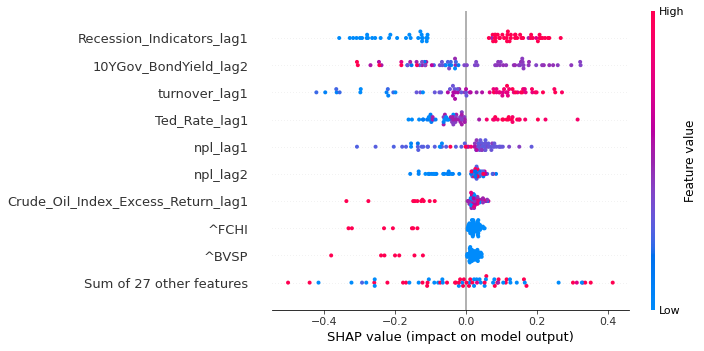

In [54]:
shap.plots.beeswarm(shap_values)

# Feature Importance

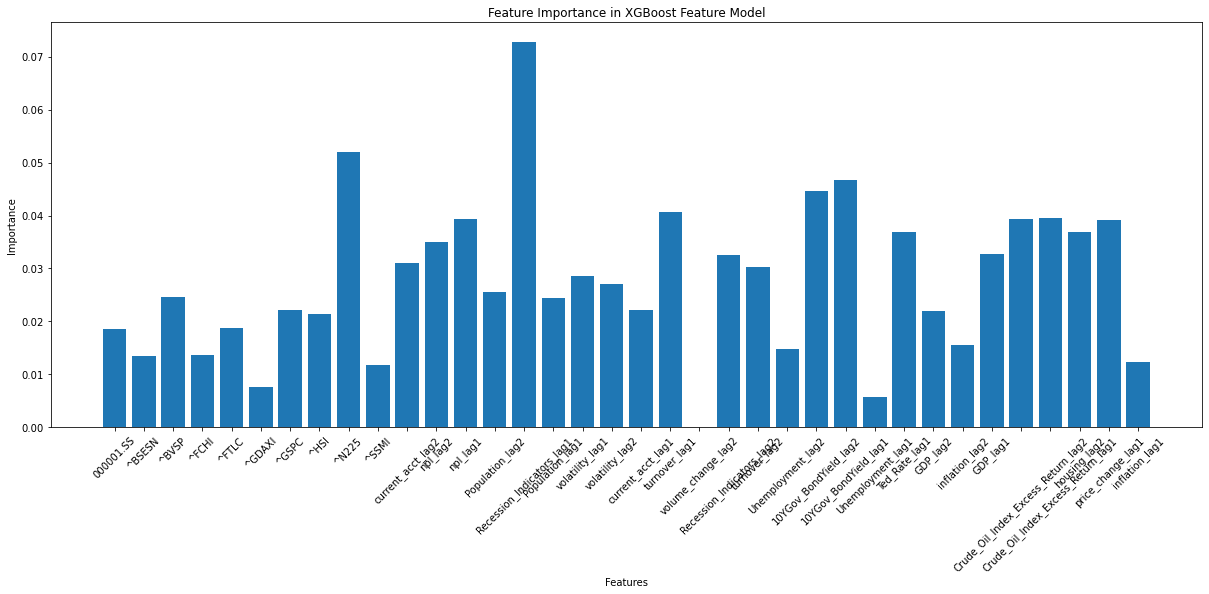

In [55]:
model_name = "XGBoost Feature"
plot_feature_importances(evaluation_df, model_name)

# AUC-ROC

In [56]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.5596380240395884


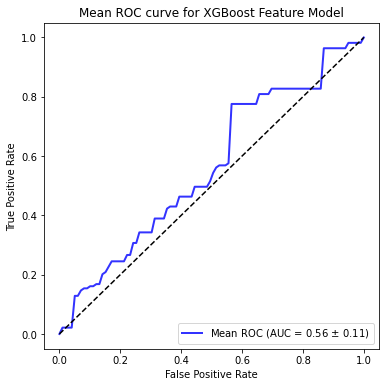

In [57]:
plot_roc_curve(evaluation_df, model_name)

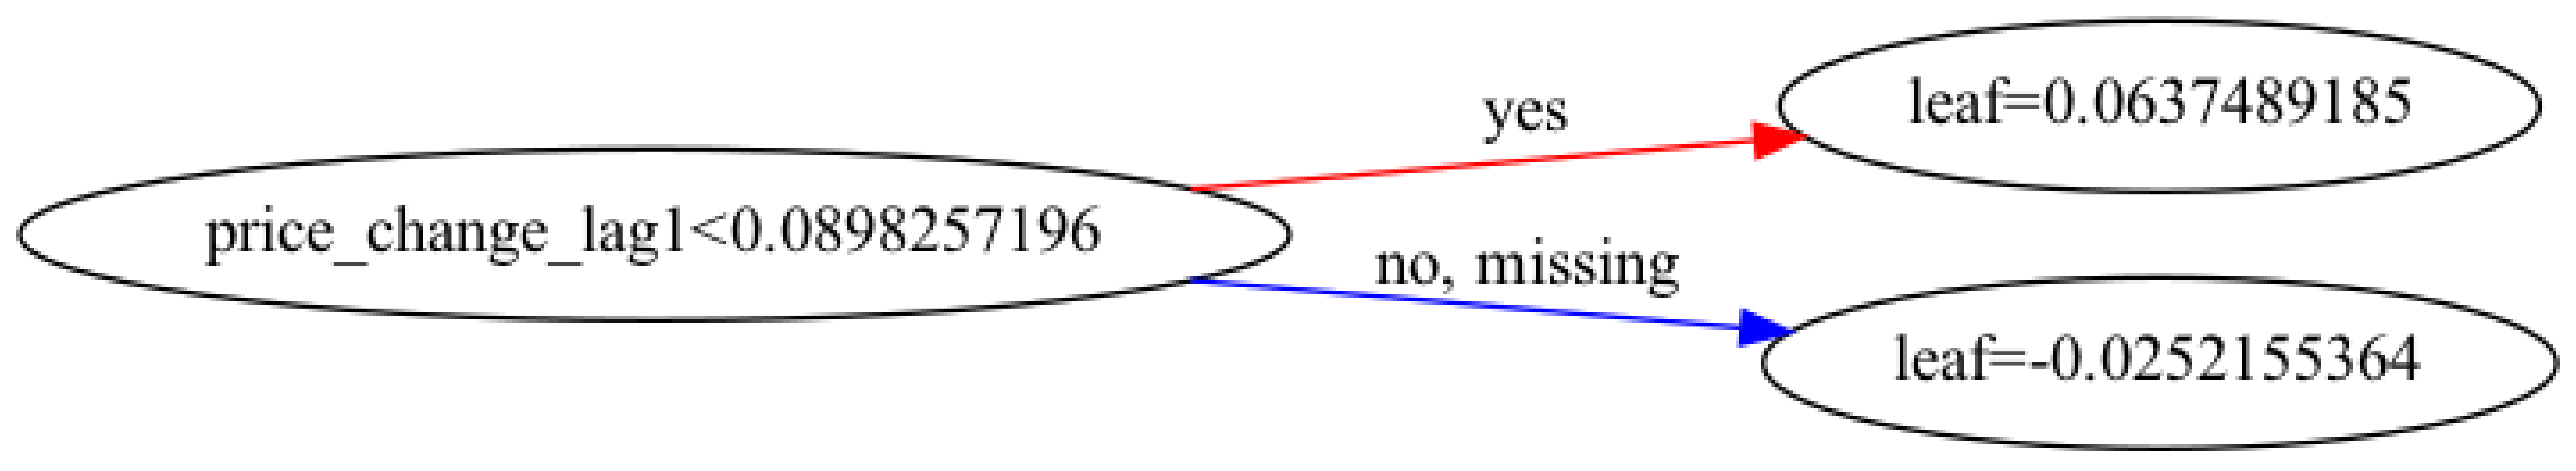

In [76]:
# pip install graphviz
fig, ax = plt.subplots(figsize=(170, 170))
xgb.plot_tree(model, ax=ax, rankdir='LR')
plt.show() 

In [79]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)